## import libraries 

In [1]:
import pandas
import configparser
import psycopg2

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [3]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## create the house table

make sure change the schema name to your gp number

In [7]:


# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS gp6.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """



use the bellow cell only if you want to delete the table

In [8]:
#conn.rollback()
#table_sql="drop table if exists demo.house"

In [9]:

cur.execute(table_sql)
conn.commit()

## define the search region

In [10]:
url = 'https://www.trulia.com/VA/Harrisonburg/90027/'

In [11]:


import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
print(html_data.decode('utf-8'))



<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><script>
            window.__uspapi = function(command, version, callback) {
              try {
                if (command === 'getUSPData') {
                  var cookies = document.cookie.split(';');
                  for (var i = 0; i < cookies.length; i++) {
                    var cookie = cookies[i];
                    var separatorIndex = cookie.indexOf('=');
                    separatorIndex = separatorIndex < 0 ? cookie.length : separatorIndex;
                    var cookie_name = decodeURIComponent(cookie.slice(0, separatorIndex).replace(/^\s+/, ''));
                    if (cookie_name === 'usprivacy') {
                      var uspString = decodeURIComponent(cookie.slice(separatorIndex + 1));
                      callback({ version: version, uspString: uspString }, true);
                      return;
                    }
                  }
                }
              } catch (ex) {
                c

In [13]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
print (soup)



<!DOCTYPE html>
<html lang="en"><head><meta charset="utf-8"/><script>
            window.__uspapi = function(command, version, callback) {
              try {
                if (command === 'getUSPData') {
                  var cookies = document.cookie.split(';');
                  for (var i = 0; i < cookies.length; i++) {
                    var cookie = cookies[i];
                    var separatorIndex = cookie.indexOf('=');
                    separatorIndex = separatorIndex < 0 ? cookie.length : separatorIndex;
                    var cookie_name = decodeURIComponent(cookie.slice(0, separatorIndex).replace(/^\s+/, ''));
                    if (cookie_name === 'usprivacy') {
                      var uspString = decodeURIComponent(cookie.slice(separatorIndex + 1));
                      callback({ version: version, uspString: uspString }, true);
                      return;
                    }
                  }
                }
              } catch (ex) {
                

## insert the records into database

In [15]:

for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp6.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass
        

## Query the Table

In [17]:
df = pandas.read_sql_query('select * from gp6.house ', conn)
df[:10]

,price,bed,bath,area,address
0,3249000,4,6,3726,"3024 Surry St, Los Angeles, CA 90027"
1,1100000,2,2,1255,"4033 Clayton Ave, Los Angeles, CA 90027"
2,3497000,5,6,3934,"4910 Los Feliz Blvd, Los Angeles, CA 90027"
3,1599000,4,3,2000,"2418 Ronda Vista Dr, Los Angeles, CA 90027"
4,899000,2,1,788,"4121 Clayton Ave, Los Angeles, CA 90027"
5,6795000,5,5,4878,"5112 Ambrose Ave, Los Angeles, CA 90027"
6,3500000,5,5,4585,"2103 N Hobart Blvd, Los Angeles, CA 90027"
7,2500000,6,5,3700,"4101 Holly Knoll Dr, Los Angeles, CA 90027"
8,7999999,4,5,2774,"2576 Aberdeen Ave, Los Angeles, CA 90027"
9,5895000,5,5,4865,"2519 Chislehurst Pl, Los Angeles, CA 90027"


## basic stat

In [19]:
df.describe()

,price,bed,bath,area
count,4.000000e+01,40.000000,40.000000,40.000000
mean,2.593257e+06,4.100000,3.675000,2947.225000
std,1.980682e+06,3.103348,1.899899,2263.002912
min,5.890000e+05,1.000000,1.000000,788.000000
25%,1.171250e+06,3.000000,2.000000,1252.500000
50%,1.619000e+06,3.000000,3.000000,2181.500000
75%,3.296250e+06,5.000000,5.000000,3778.000000
max,8.250000e+06,21.000000,8.000000,12959.000000


## price distribution

<AxesSubplot:>

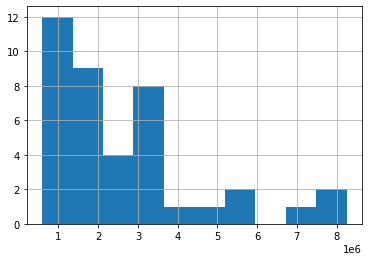

In [22]:
df['price'].hist()

## bed vs bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

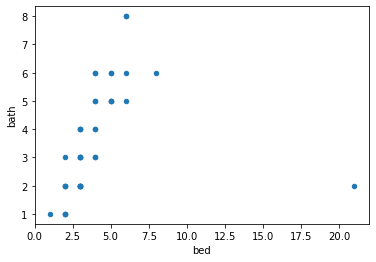

In [23]:
df.plot.scatter(x='bed',y='bath')